In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.stats import norm

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Initialize the PorterStemmer
stemmer = PorterStemmer()

# Load the dataset
file_path = '../data/feis_sirs_demo_merged'
df = pd.read_pickle(file_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/orenpoleshuckkinel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/orenpoleshuckkinel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['na'] not in stop_words.
  warnings.warn(


Topics identified in all responses:
Topic 1: famili support access health
Topic 2: provid respit support behavior
Topic 3: hab support home respit
Topic 4: answer famili individu respit
Topic 5: respit commun crisi habilit

Percent of responses in each topic before COVID-19:
Topic 1: 24.70%
Topic 2: 21.69%
Topic 3: 21.69%
Topic 4: 17.47%
Topic 5: 14.46%

Percent of responses in each topic after COVID-19:
Topic 1: 18.40%
Topic 2: 26.40%
Topic 3: 17.60%
Topic 4: 25.60%
Topic 5: 12.00%


/var/folders/ss/3094bd1s7k55hnfygclmswz00000gn/T/ipykernel_7177/1367226041.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_covid_df['topic'] = df.loc[before_covid_df.index, 'topic']
/var/folders/ss/3094bd1s7k55hnfygclmswz00000gn/T/ipykernel_7177/1367226041.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_covid_df['topic'] = df.loc[after_covid_df.index, 'topic']


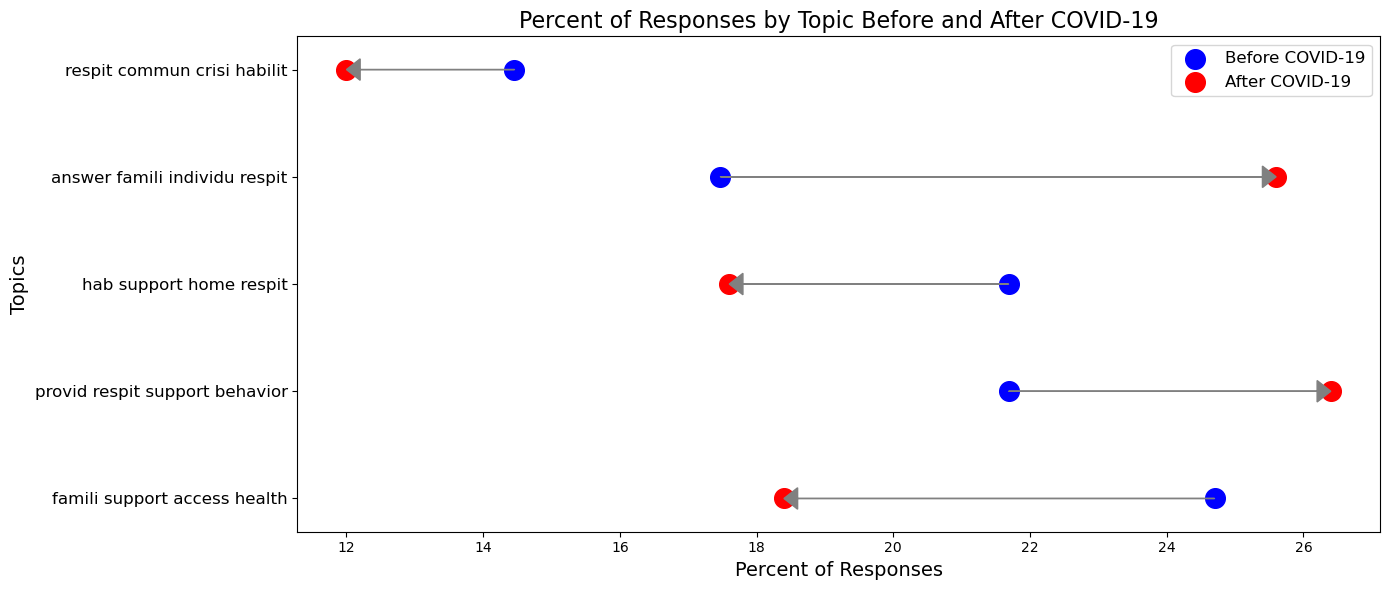

In [2]:
# Extract relevant text columns
text_columns = [
    'If yes, please describe the service.',
    'What\nadvice would you give to service planners regarding the mental health service\nneeds of persons with IDD and their families?'
]
date_column = 'End Date'

# Ensure the Date column is in datetime format
df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

# Combine the text columns into a single text corpus
df['combined_text'] = df[text_columns].fillna('').astype(str).apply(lambda row: ' '.join(row), axis=1)

# Define the COVID-19 start date and the one year period before it
covid_start_date = pd.Timestamp('2020-03-13')
one_year_before_covid = covid_start_date - pd.DateOffset(years=1)

# Filter the dataset for the one year before COVID-19
before_covid_df = df[(df[date_column] >= one_year_before_covid) & (df[date_column] < covid_start_date)]
after_covid_df = df[df[date_column] >= covid_start_date]

# Preprocess the text data
custom_stopwords = ['services', 'need', 'help', 'know', 'would', 'many', 'needs', 'none', 'N/A', 'provided', 'nothing', 'unknown', 'NA', 'no']
stop_words = list(set(stopwords.words('english'))) + custom_stopwords

# Tokenize and stem the text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

df['tokenized_text'] = df['combined_text'].apply(preprocess_text)

# Apply CountVectorizer
vectorizer = CountVectorizer(stop_words=stop_words)
text_matrix = vectorizer.fit_transform(df['tokenized_text'])

# Apply LDA for topic modeling
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=69)
lda.fit(text_matrix)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(' '.join(topic_words))
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, 4)  # top 4 words per topic

# Get topic distribution for each document
topic_distribution = lda.transform(text_matrix)

# Assign each document to the most probable topic
df['topic'] = np.argmax(topic_distribution, axis=1)

# Count the number of cases in each topic before and after COVID
before_covid_df['topic'] = df.loc[before_covid_df.index, 'topic']
after_covid_df['topic'] = df.loc[after_covid_df.index, 'topic']

before_covid_topic_counts = before_covid_df['topic'].value_counts().reindex(range(n_topics), fill_value=0)
after_covid_topic_counts = after_covid_df['topic'].value_counts().reindex(range(n_topics), fill_value=0)

# Calculate proportions and convert to percentages
before_covid_percentages = (before_covid_topic_counts / before_covid_df.shape[0]) * 100
after_covid_percentages = (after_covid_topic_counts / after_covid_df.shape[0]) * 100

# Display the topics and their counts for both subsets
print("Topics identified in all responses:")
for idx, topic in enumerate(topics):
    print(f"Topic {idx+1}: {topic}")

print("\nPercent of responses in each topic before COVID-19:")
for idx in range(n_topics):
    print(f"Topic {idx+1}: {before_covid_percentages[idx]:.2f}%")

print("\nPercent of responses in each topic after COVID-19:")
for idx in range(n_topics):
    print(f"Topic {idx+1}: {after_covid_percentages[idx]:.2f}%")

# Plot the change in the percent of responses that fall into each category pre- and post-COVID
labels = topics  # Use the topics as labels
y = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(14, 6))

# Scatter plot for before COVID-19 percentages
ax.scatter(before_covid_percentages, y, color='blue', label='Before COVID-19', s=200)  # Increased size of dots

# Scatter plot for after COVID-19 percentages
ax.scatter(after_covid_percentages, y, color='red', label='After COVID-19', s=200)  # Increased size of dots

# Add arrows to show the direction of change
for i in range(len(y)):
    if after_covid_percentages[i] < before_covid_percentages[i]:
        adjust_dx = 0.2
    else:
        adjust_dx = -0.2
    dx = after_covid_percentages[i] - before_covid_percentages[i] + adjust_dx
    ax.arrow(before_covid_percentages[i], y[i], dx, 0, 
             head_width=0.2, head_length=0.2, 
             fc='gray', ec='gray')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Topics', fontsize=14)  # Increased font size
ax.set_xlabel('Percent of Responses', fontsize=14)  # Increased font size
ax.set_title('Percent of Responses by Topic Before and After COVID-19', fontsize=16)  # Increased font size
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=12)  # Increased font size
ax.legend(fontsize=12)  # Increased font size

fig.tight_layout()

plt.savefig('percent_responses_topic_pre_post_covid.png')

plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['na'] not in stop_words.
  warnings.warn(
/var/folders/ss/3094bd1s7k55hnfygclmswz00000gn/T/ipykernel_7177/1493119862.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df['topic'] = np.argmax(topic_distribution, axis=1)


Analyzing groups and collecting data:

Analyzing group: Asian/Pacific Islander
Number of records for Asian/Pacific Islander: 26

Analyzing group: White
Number of records for White: 316

Analyzing group: Hispanic/Latinx
Number of records for Hispanic/Latinx: 34

Analyzing group: American Indian or Alaska Native
Number of records for American Indian or Alaska Native: 0
No data found for group: American Indian or Alaska Native

Analyzing group: Black/African American
Number of records for Black/African American: 101

Analyzing group: Other/Unknown
Number of records for Other/Unknown: 54


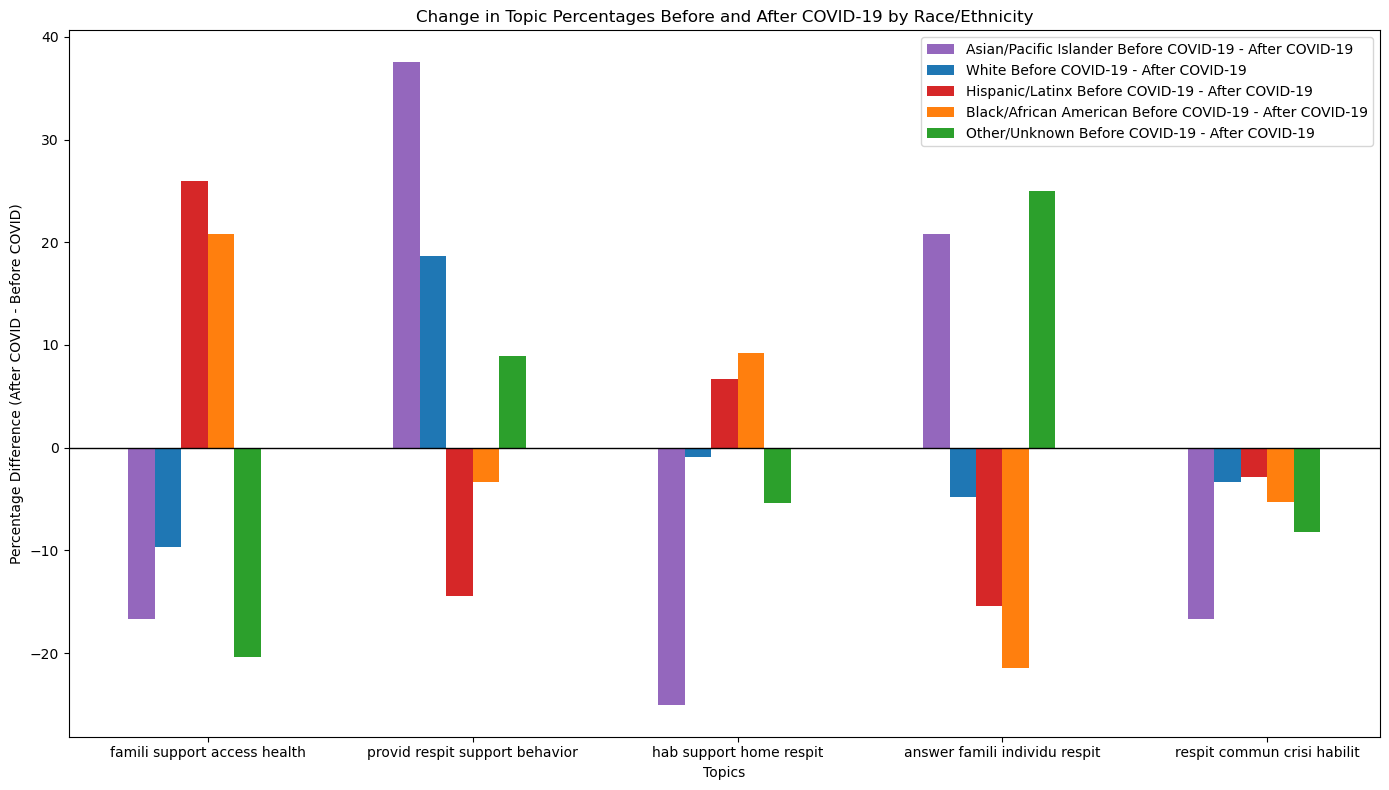

In [3]:
# Function to analyze each group and get data for plotting
def analyze_group_data(df, group_name, date_column, covid_start_date, stop_words, n_topics, topics):
    print(f"\nAnalyzing group: {group_name}")
    
    group_df = df[df['race_clean'] == group_name]
    print(f"Number of records for {group_name}: {len(group_df)}")
    
    if group_df.empty:
        print(f"No data found for group: {group_name}")
        return None, None, None
    
    # Apply CountVectorizer and LDA for topic modeling
    vectorizer = CountVectorizer(stop_words=stop_words)
    text_matrix = vectorizer.fit_transform(group_df['tokenized_text'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=69)
    lda.fit(text_matrix)
    
    topic_distribution = lda.transform(text_matrix)
    group_df['topic'] = np.argmax(topic_distribution, axis=1)

    before_covid_group_df = group_df[group_df[date_column] < covid_start_date]
    after_covid_group_df = group_df[group_df[date_column] >= covid_start_date]

    before_covid_topic_counts = before_covid_group_df['topic'].value_counts().reindex(range(n_topics), fill_value=0)
    after_covid_topic_counts = after_covid_group_df['topic'].value_counts().reindex(range(n_topics), fill_value=0)

    before_covid_percentages = (before_covid_topic_counts / before_covid_group_df.shape[0]) * 100
    after_covid_percentages = (after_covid_topic_counts / after_covid_group_df.shape[0]) * 100

    return before_covid_percentages, after_covid_percentages, topics

# Define color mapping for races
colors = {
    'White': '#1f77b4',
    'Black/African American': '#ff7f0e',
    'Other/Unknown': '#2ca02c',
    'Hispanic/Latinx': '#d62728',
    'Asian/Pacific Islander': '#9467bd',
    'American Indian or Alaska Native': '#e377c2',
}

# Function to create a grouped bar chart
def create_grouped_bar_chart(data, topics):
    num_topics = len(topics)
    bar_width = 0.1  # Adjust bar width to fit all groups
    index = np.arange(num_topics)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for idx, (group_name, (before_percentages, after_percentages)) in enumerate(data.items()):
        differences = np.array(after_percentages) - np.array(before_percentages)
        ax.bar(index + idx * bar_width, differences, bar_width, label=f'{group_name} Before COVID-19 - After COVID-19', color=colors.get(group_name, '#333333'))
    
    ax.set_xlabel('Topics')
    ax.set_ylabel('Percentage Difference (After COVID - Before COVID)')
    ax.set_title('Change in Topic Percentages Before and After COVID-19 by Race/Ethnicity')
    ax.set_xticks(index + bar_width * (len(data) / 2))
    ax.set_xticklabels([topics[i] for i in range(num_topics)])
    ax.legend()
    
    # Add a horizontal line at 0%
    ax.axhline(0, color='black', linewidth=1, linestyle='-')
    
    plt.xticks(rotation=0)
    plt.tight_layout()

# List of groups to analyze in the specified order
groups = ['Asian/Pacific Islander', 'White', 'Hispanic/Latinx', 'American Indian or Alaska Native', 'Black/African American', 'Other/Unknown']

# Dictionary to hold the data for each group
group_data = {}

print("Analyzing groups and collecting data:")
for group in groups:
    before_percentages, after_percentages, returned_topics = analyze_group_data(df, group, date_column, covid_start_date, stop_words, n_topics, topics)
    if before_percentages is not None and after_percentages is not None:
        group_data[group] = (before_percentages, after_percentages)

# Create the grouped bar chart
create_grouped_bar_chart(group_data, topics)

plt.savefig('../output/Change in Topic Percentages Before and After COVID-19 by Race and Ethnicity.png')

plt.show()

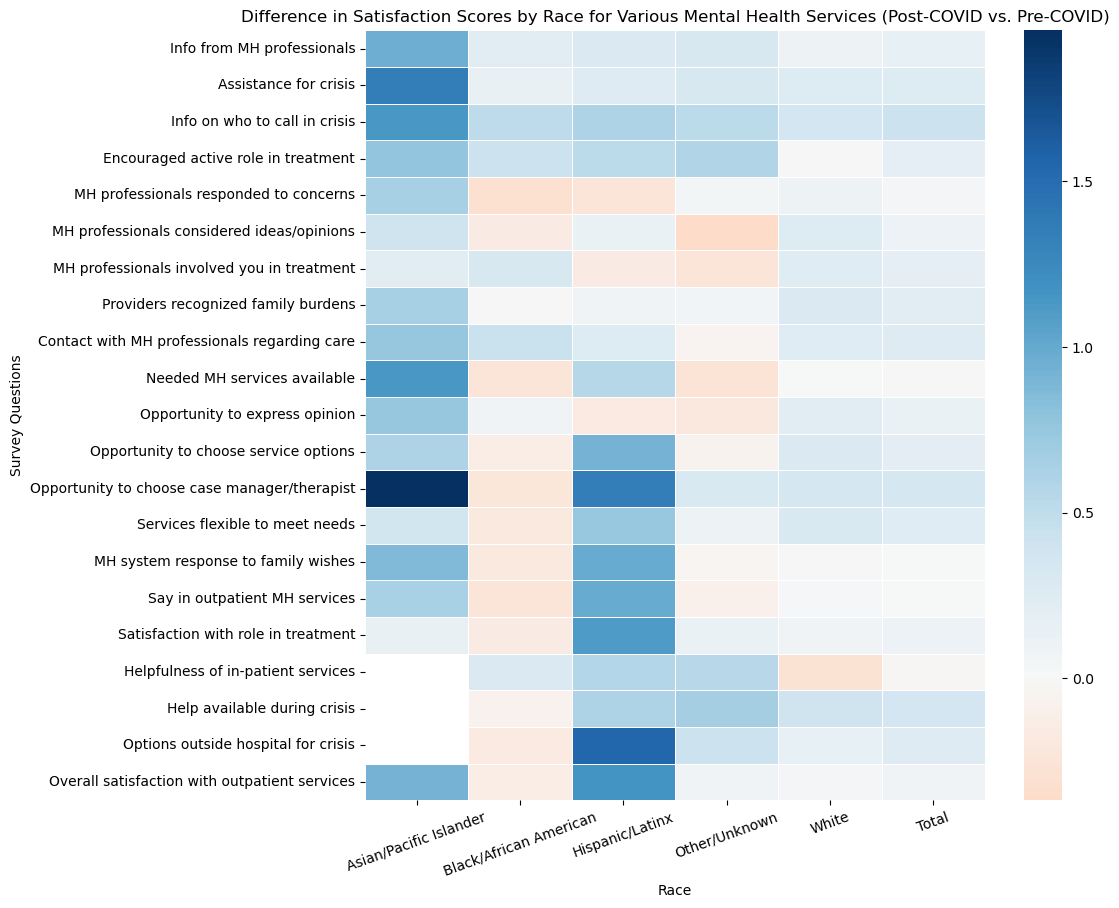

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../data/feis_sirs_demo_merged'
df = pd.read_pickle(file_path)

# Define a dictionary to rename columns
column_rename_mapping = {
    'Over the past year, how much information did you receive from your family memberâ€™s mental health professionals (psychiatrist, therapist, case manager, etc.) regarding his/her illness?': 'Info from MH professionals',
    'How much assistance did you get from mental\nhealth professionals regarding\nwhat to do if there were to be a crisis involving your family member?': 'Assistance for crisis',
    'How much information did you get from mental\nhealth professionals regarding whom to call if there were to be a crisis\ninvolving your family member?': 'Info on who to call in crisis',
    'How\nmuch were you encouraged by mental health professionals to take an active role\nin your family memberâ€™s outpatient treatment?': 'Encouraged active role in treatment',
    'During the past year, how much did mental\nhealth professionals respond to your concerns about your family member?': 'MH professionals responded to concerns',
    'How\nmuch did mental health professionals take into account your ideas and opinions\nabout your family memberâ€™s treatment?': 'MH professionals considered ideas/opinions',
    'When\nyou had your family memberâ€™s permission, how much did mental health\nprofessionals involve you in his/her treatment?': 'MH professionals involved you in treatment',
    'During\nthe past year, how much did outpatient service providers recognize the burdens\nthat family members like you face?': 'Providers recognized family burdens',
    'If\nyes, how much contact did you have with any mental health professional on any\nmatter pertaining to your family memberâ€™s care?': 'Contact with MH professionals regarding care',
    'Were\nthe available mental health services for your family member the ones you\nthought were needed?': 'Needed MH services available',
    'How much opportunity was there for you to\nexpress your opinion to mental health providers about the treatment your family\nmember received?': 'Opportunity to express opinion',
    'How\nmuch opportunity did you or your family member have to choose between different\nmental health service options?': 'Opportunity to choose service options',
    'During the past year, how much opportunity\ndid you or your family member have to choose a particular case manager or\ntherapist?': 'Opportunity to choose case manager/therapist',
    'During\nthe past year, how convenient was it for your family member to use mental\nhealth services (i.e. were services easy to access)?': 'Convenience of MH services',
    'During the past year, have the services\noffered been flexible enough to meet the needs of you and your family\nmember.': 'Services flexible to meet needs',
    'How much did you feel that the mental health\nsystem was responding to the wishes of family members like yourself?': 'MH system response to family wishes',
    'During\nthe past year, how much say did you have in the outpatient mental health\nservices that your family member received?': 'Say in outpatient MH services',
    'How\nmuch satisfaction did you feel about your role in your family memberâ€™s\ntreatment?': 'Satisfaction with role in treatment',
    'If\nyes, were the inpatient services that your family member received helpful to\nhim/her in your opinion?  ?': 'Helpfulness of in-patient services',
    'How\nmuch help was available to you at night or on weekends if your family member\nhad a crisis?': 'Help available during crisis',
    'Are\nthere options outside of the hospital for individuals experiencing a crisis to\ngo for help (i.e. crisis/hospital diversion beds)?': 'Options outside hospital for crisis',
    'During the past year, in general how\nsatisfied were you with the outpatient mental health services your family\nmember received?': 'Overall satisfaction with outpatient services',
}

# Rename the columns
df = df.rename(columns=column_rename_mapping)

# List of columns to be classified
qualitative_columns_renamed = list(column_rename_mapping.values())

# Classification dictionary
classification = {
    'All that was wanted/needed': 4,
    'Some, but not as much as was needed/wanted': 3,
    'Very little': 2,
    'None at all': 1,
    'Very satisfied': 4,
    'Somewhat satisfied': 3,
    'Somewhat dissatisfied': 2,
    'Not satisfied at all': 1,
    'Easy to access': 4,
    'Somewhat easy to access': 3,
    'Somewhat difficult to access': 2,
    'Could not access': 1,
    'As flexible as was wanted/needed': 4,
    'Some flexibility, but not as much as was needed/wanted': 3,
    'Very little flexibility': 2,
    'Not flexible at all': 1,
    'Did not know/answer': None
}
# Replace qualitative responses with numerical values
df_classified = df[['race_clean', 'End Date'] + qualitative_columns_renamed].replace(classification)

# Convert 'End Date' to datetime
df_classified['End Date'] = pd.to_datetime(df_classified['End Date'])

# Filter data pre- and post-COVID
pre_covid = df_classified[df_classified['End Date'] < '2020-03-13']
post_covid = df_classified[df_classified['End Date'] >= '2020-03-13']

# Ensure only numeric columns are considered for mean calculation
numeric_columns = df_classified.select_dtypes(include=['number']).columns.tolist()

# Calculate counts for pre- and post-COVID
pre_covid_counts = pre_covid.groupby('race_clean')[numeric_columns].count()
post_covid_counts = post_covid.groupby('race_clean')[numeric_columns].count()

# Calculate average scores for pre- and post-COVID
average_pre_covid = pre_covid.groupby('race_clean')[numeric_columns].mean()
average_post_covid = post_covid.groupby('race_clean')[numeric_columns].mean()

# Calculate the difference in satisfaction scores
difference_scores = average_post_covid - average_pre_covid

# Mask values where counts are less than 3
mask = (pre_covid_counts < 2) | (post_covid_counts < 2)
difference_scores = difference_scores.mask(mask)

# Calculate total satisfaction scores without considering race
total_satisfaction_pre_covid = pre_covid[numeric_columns].mean()
total_satisfaction_post_covid = post_covid[numeric_columns].mean()
total_difference_scores = total_satisfaction_post_covid - total_satisfaction_pre_covid
difference_scores.loc['Total'] = total_difference_scores

# Plotting race vs. difference in satisfaction scores as a heatmap with blue as good and red as bad
plt.figure(figsize=(10, 10))
sns.heatmap(difference_scores.T, cmap='RdBu', linewidths=.5, center = 0)
plt.title('Difference in Satisfaction Scores by Race for Various Mental Health Services (Post-COVID vs. Pre-COVID)')
plt.xlabel('Race')
plt.xticks(rotation=20)
plt.ylabel('Survey Questions')
plt.savefig('../output/Difference in Satisfaction Scores by Race for Various Mental Health Services (Post-COVID vs. Pre-COVID).png', bbox_inches='tight')
plt.show()